# Variational Quantum Eigensolver(VQE)で励起状態の計算

VQEではハミルトニアンの期待値が小さくなるよう波動関数を最適化していきます。そのため、VQEをそのまま使うと基底状態しか求めることができません。今回はVQEを用いて励起状態を計算する手法を解説し、例として水素分子の励起状態の計算を行います。

## 理論概要
今回は[Overlapに基づいた方法](https://quantum-journal.org/papers/q-2019-07-01-156/)を使用して第一励起状態を計算します。この方法はVQEで得られた波動関数と基底状態の波動関数同士の重なりに関するペナルティ項をハミルトニアンに追加することで、励起状態をVQEで計算させます。式で書くと以下の通りです。
$$
H^\prime=H+\alpha \mid \psi_{gs}\rangle\langle\psi_{gs} \mid 
$$
右辺の$H$は元々のハミルトニアンです。右辺の二項目で基底状態の波動関数$ \mid \psi_{gs}\rangle$との重なりの大きさを評価します（今回は$ \mid \psi_{gs}\rangle$は古典計算で求めますが、VQEを用いて求めることも可能です）。$\alpha$はペナルティを表すパラメーターで、十分大きく取ります。そして、$H$に波動関数の重なりに関するペナルティ項を加えたものを新たに$H^\prime$と定義します。

VQEから得られた波動関数$ \mid \psi_{VQE}\rangle$を$H^\prime$に挟んだ期待値を評価します。
$$
\langle\psi_{VQE} \mid H^\prime \mid \psi_{VQE}\rangle=\langle\psi_{VQE} \mid H \mid \psi_{VQE}\rangle+\alpha\langle\psi_{VQE} \mid \psi_{gs}\rangle\langle\psi_{gs} \mid \psi_{VQE}\rangle\\
=\langle\psi_{VQE} \mid H \mid \psi_{VQE}\rangle+\alpha \mid \langle\psi_{gs} \mid \psi_{VQE}\rangle \mid^2
$$
励起状態は基底状態と直交しているため、$ \mid \psi_{VQE}\rangle$が励起状態となった場合、上式の第二項目は0となります。今回はこの期待値を用いて、VQEで水素分子の励起状態計算の実装を行います。

ちなみにもし、欲しい波動関数が第一励起状態ではなく第N励起状態である場合は、基底状態から第N-1励起状態までの波動関数を用いてペナルティを作成します。
$$
H^\prime=H+\sum_{i=gs}^{N-1}\alpha_i \mid \psi_{i}\rangle\langle\psi_{i} \mid 
$$

## 準備
必要なライブラリをインストールします。水素分子のハミルトニアンはOpenFermionで取得します。

In [ ]:
!pip3 install blueqat openfermion

必要なライブラリをインポートします。VQEの最適化はSciPyのminimizeで行います。

In [2]:
from blueqat import Circuit
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
import numpy as np
from scipy.optimize import minimize

## Ansatzの定義と分子の情報取得
VQE計算と分子の情報取得を行う関数を定義します。VQEはHardware Efficient Ansatzを用いて計算します。水素分子の初期波動関数は$\mid1010\rangle$に設定します。
分子情報の取得はOpenFermionを用います。基底関数はSTO-3Gです。

In [3]:
def HEA(params,n_qubits,n_depth):
    #波動関数初期化 |1010>
    circ=Circuit().x[1, 3]

    #量子回路作成
    params_devided=np.array_split(params,n_depth)
    for params_one_depth in params_devided:
        for i,param in enumerate(params_one_depth):
            if i < n_qubits:
                circ.ry(param)[i]
            else:
                circ.rz(param)[i%n_qubits]
        for qbit in range(n_qubits):
            if qbit < n_qubits-1:
                circ.cz[qbit,qbit+1]
    
    #量子回路実行
    wf = circ.run(backend="numpy")
    return wf

def get_molecule(length):
    geometry = [('H',(0.,0.,0.)),('H',(0.,0.,length))]
    try:
        description = f'{length:.2f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    except:
        description = f'{length:.1f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    return molecule

## 期待値とコスト関数
VQEで得られた波動関数を使用して、期待値計算を行います。期待値計算では、基底状態とVQEの波動関数同士の重なりに関する項を元々のハミルトニアンの期待値に加えます。

In [4]:
def expect_exited_state(wf,hamiltonian,penalty,wf_gs):
    #ハミルトニアンと基底状態との重なりによるペナルティ値を計算
    hamiltonian_overlap = np.vdot(wf, hamiltonian.dot(wf)).real+penalty*np.abs(np.vdot(wf_gs,wf))**2
    return hamiltonian_overlap

def cost(params,hamiltonian,n_qubits,n_depth,penalty,wf_gs):
    wf=HEA(params,n_qubits,n_depth)
    return expect_exited_state(wf,hamiltonian,penalty,wf_gs)

## 計算実行とプロット
各結合長でVQEを実行します(数分かかります)。今回は基底状態の波動関数を古典的に求めますが、VQEを用いて事前に計算しておくこともできます。ペナルティの値は10 Hartreeとしました。
計算後、エネルギーと結合長に関してVQEと基底状態、第一励起状態の計算結果を比較します。

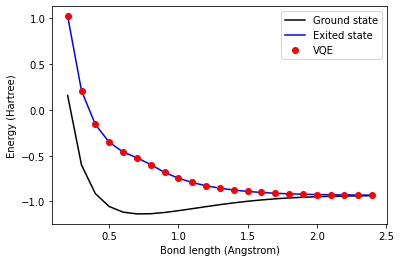

In [5]:
#結合長、VQE、基底状態、第一励起状態の結果記録用
bond_len_list = [];VQE_energy_list=[];gs_list=[];es_list=[]
#各結合長で計算実行
for bond_len in np.arange(0.2,2.5,0.1):
    molecule = get_molecule(bond_len)
    #ビット数、深さ、パラメーター初期値、ペナルティ値を決める
    n_qubits=molecule.n_qubits
    n_depth=4
    init_params=np.random.rand(2*n_qubits*n_depth)*0.1
    penalty=10
    #ハミルトニアン定義
    hamiltonian_gs = get_sparse_operator(jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian())))

    #ハミルトニアンの厳密対角化から固有値固有ベクトルを古典的に計算
    eigen_energy, eigen_vec =np.linalg.eigh((hamiltonian_gs).toarray())
    #基底状態の波動関数取得
    wf_gs=eigen_vec.T[np.argmin(eigen_energy)]

    #最適化実行
    result=minimize(cost,x0=init_params,args=(hamiltonian_gs,n_qubits,n_depth,penalty,wf_gs))

    #結合長、VQE、基底状態、第一励起状態の結果記録
    bond_len_list.append(bond_len)
    VQE_energy_list.append(result.fun)
    gs_list.append(sorted(eigen_energy)[0])
    es_list.append(sorted(eigen_energy)[1])

#プロット
import matplotlib.pyplot as plt
plt.plot(bond_len_list,gs_list,label="Ground state",color="black")
plt.plot(bond_len_list,es_list,label="Exited state",color="blue")
plt.plot(bond_len_list,VQE_energy_list, marker="o",label="VQE",color="red",linestyle='None')
plt.xlabel("Bond length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()

厳密な値とよく一致した励起状態が求まりました。今回用いた励起状態手法はOverlapに基づく方法ですが、この他にも様々な手法が存在するので、例えば[こちらのレビュー](https://arxiv.org/abs/1808.10402)などを参考に目的に合った手法を試してもよいと思います。